# HandCrafted Crack Segmentation

## 1. Libraries

In [44]:
import cv2
import tqdm
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters
import time
import itertools

## 2. Mount Drive to load datasets

In [45]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


## 3. Images

In [46]:
test_path = '/content/drive/MyDrive/crack_segmentation_dataset/test/images/'
test_txt = open('/content/drive/MyDrive/crack_segmentation_dataset/test/test_small.txt', 'r')
lines = test_txt.readlines()
test_paths = []
for line in lines:
  test_paths.append(test_path+line.strip()+'.jpg')

In [47]:
test_paths[0] # Es normal si la imagen termina en .jpg.jpg, es error del dataset pero no afecta la lectura de la imagen

'/content/drive/MyDrive/crack_segmentation_dataset/test/images/noncrack_noncrack_concrete_wall_96_2.jpg.jpg'

## 4. Metrics

In [48]:
def accuracy_score(y_true, y_pred):
    return np.mean(y_true == y_pred)

def intersection_over_union(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / (np.sum(union) + 1e-8)
    return iou_score

## 5. Algoritmo

In [49]:
# CÓDIGO DE EJEMPLO QUE VENÍA EN EL NOTEBOK

def segment_cracks(image_path, vis = False):
    # Read the grayscale image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Read mask
    mask_path = image_path.replace('images', 'masks')
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Apply Gaussian Blur to reduce noise
    blurred = cv2.bilateralFilter(image, d=15, sigmaColor=75, sigmaSpace=75)

    # Usar umbralización adaptativa
    #thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    #                               cv2.THRESH_BINARY_INV, 11, 2)
    _,thresh = cv2.threshold(blurred,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    # Use Canny edge detection to find edges
    edges = cv2.Canny(blurred, threshold1=50, threshold2=200)

    # Use morphological operations to close gaps in cracks
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # Find contours of the segmented cracks

    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create an output image to draw contours
    output = np.zeros_like(image)

    # Draw contours on the output image
    for contour in contours:
        if cv2.contourArea(contour) > 500:  # Filter out small areas
            cv2.drawContours(output, [contour], -1, 255, thickness=cv2.FILLED)

    if vis:
      # Display the results
      plt.figure(figsize=(12, 6))
      plt.subplot(1, 6, 1)
      plt.title('Original Image')
      plt.imshow(image, cmap='gray')
      plt.axis('off')

      plt.subplot(1, 6, 2)
      plt.title('Mask')
      plt.imshow(mask, cmap='gray')
      plt.axis('off')

      plt.subplot(1, 6, 3)
      plt.title('Blurred Image')
      plt.imshow(blurred, cmap='gray')
      plt.axis('off')

      plt.subplot(1, 6, 4)
      plt.title('Thresholded Image')
      plt.imshow(thresh, cmap='gray')
      plt.axis('off')

      plt.subplot(1, 6, 5)
      plt.title('Edge Detection')
      plt.imshow(edges, cmap='gray')
      plt.axis('off')

      plt.subplot(1, 6, 6)
      plt.title('Segmented Cracks')
      plt.imshow(output, cmap='gray')
      plt.axis('off')

      plt.tight_layout()
      plt.show()

    return closed, mask

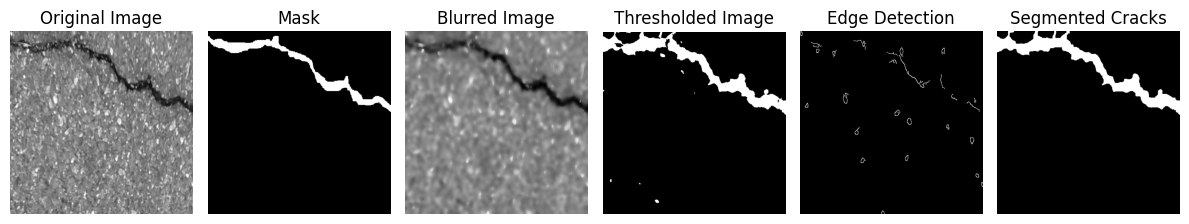

Inference time for segment_cracks: 1.7082 seconds


In [50]:
# Choose an image path from our small test set
image_path = test_paths[10]

# Measure inference time with visualization
start_time = time.time()
result, mask = segment_cracks(image_path, vis=True)
end_time = time.time()

inference_time = end_time - start_time

print(f"Inference time for segment_cracks: {inference_time:.4f} seconds")

In [51]:
accs = []
ious = []
for pdx, path in enumerate(tqdm.tqdm(test_paths)):
  #if pdx < 10:
  #  continue
  result, mask = segment_cracks(path)
  acc = accuracy_score(mask, result)
  iou = intersection_over_union(mask, result)
  accs.append(acc)
  ious.append(iou)
  #break

100%|██████████| 169/169 [00:19<00:00,  8.78it/s]


In [52]:
# print mean accuracy and mean iou in %
print(f"Mean accuracy: {np.mean(accs) * 100:.2f}%")
print(f"Mean IoU: {np.mean(ious) * 100:.2f}%")

Mean accuracy: 54.62%
Mean IoU: 8.48%


A continuación se mostrará la elaboración propia para la segmentación de grietas de la tarea anterior. Los pasos que se siguieron en esa ocasión fueron:
1. Conversión a escala de grises.
2. Aplicación de filtro gaussiano.
3. Detección de bordes usando Canny.
4. Operación morfológica de cierre.

In [53]:
def my_segmentation_cracks(image_path, vis = False):
    '''
    Recibe de entrada el PATH a una imagen de grieta y desarrolla
    cuatro procesos para la segmentación de la grieta:
    1. Conversión a escala de grises.
    2. Aplicación de filtro gaussiano.
    3. Detección de bordes usando Canny.
    4. Operación morfológica de cierre.

    Args
        image_path (str): PATH en donde se tiene almacenada la imagen.
        vis (bool): Permite ver gráficamente el resultado de la segmentación.

    Return
        closed (): La imagen segmentada.
        mask (): La máscara de la imagen de entrada.
    '''
    # Lectura de la máscara
    mask_path = image_path.replace('images', 'masks')
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Lectura y conversión a escala de grises
    imagen_rgb = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    imagen_gray = cv2.cvtColor(imagen_rgb, cv2.COLOR_RGB2GRAY)

    # Aplicación de filtro gaussiano
    imagen_blur = cv2.GaussianBlur(imagen_gray, (3, 3), 0)

    # Detección de bordes usando Canny
    imagen_canny = cv2.Canny(imagen_blur, 50, 200)

    # Operación morfológica de cierre
    imagen_cierre = cv2.morphologyEx(imagen_canny, cv2.MORPH_CLOSE,np.ones((3,3), np.uint8), iterations=2)

    if vis:
      # Display the results
      plt.figure(figsize=(10, 6))
      plt.subplot(1, 5, 1)
      plt.title('Original Image')
      plt.imshow(imagen_rgb, cmap='gray')
      plt.axis('off')

      plt.subplot(1, 5, 2)
      plt.title('Mask')
      plt.imshow(mask, cmap='gray')
      plt.axis('off')

      plt.subplot(1, 5, 3)
      plt.title('Blurred Image')
      plt.imshow(imagen_blur, cmap='gray')
      plt.axis('off')

      plt.subplot(1, 5, 4)
      plt.title('Edge Detection')
      plt.imshow(imagen_canny, cmap='gray')
      plt.axis('off')

      plt.subplot(1, 5, 5)
      plt.title('Segmented Cracks')
      plt.imshow(imagen_cierre, cmap='gray')
      plt.axis('off')

      plt.tight_layout()
      plt.show()

    return imagen_cierre, mask

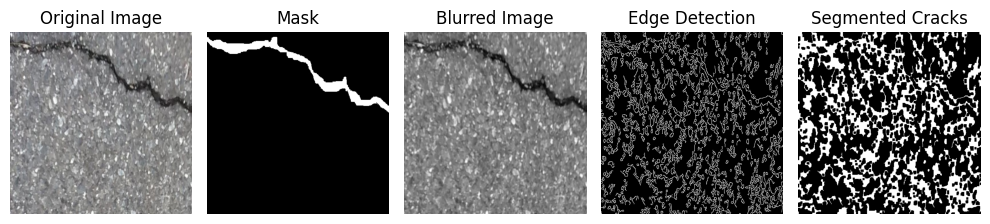

Inference time for segment_cracks: 1.0940 seconds


In [54]:
# Choose an image path from our small test set
image_path = test_paths[10]

# Measure inference time with visualization
start_time = time.time()
result, mask = my_segmentation_cracks(image_path, vis=True)
end_time = time.time()

inference_time = end_time - start_time

print(f"Inference time for segment_cracks: {inference_time:.4f} seconds")

In [55]:
accs = []
ious = []
for pdx, path in enumerate(tqdm.tqdm(test_paths)):
  #if pdx < 10:
  #  continue
  result, mask = my_segmentation_cracks(path)
  acc = accuracy_score(mask, result)
  iou = intersection_over_union(mask, result)
  accs.append(acc)
  ious.append(iou)
  #break

100%|██████████| 169/169 [00:08<00:00, 19.73it/s]


In [56]:
# print mean accuracy and mean iou in %
print(f"Mean accuracy: {np.mean(accs) * 100:.2f}%")
print(f"Mean IoU: {np.mean(ious) * 100:.2f}%")

Mean accuracy: 75.69%
Mean IoU: 8.21%


Como se puede ver, los resultados son bastante malos, ya que detecta como grieta la misma textura del pavimento, perdiendo así la grieta de verdad. Si nos fijamos en el `IoU` se obtuvo un menos del $10\%$ en coincidencias con la grieta real, por lo que hay un amplio margen de mejora en este algoritmo. Para ello haremos las siguientes modificaciones a esta función de segmentación:

1. Aplicación de filtro mediana sobre suavizado gaussiano.
2. Mejora de contraste entre pavimento y grieta.
3. Aplicación de filtro de contorno

In [ ]:
import cv2
import numpy as np
import tqdm

def evaluate_on_dataset(image_paths, params):
    """
    Evalúa un conjunto de imágenes usando umbralización adaptativa y operaciones morfológicas.

    Args:
        image_paths (list): Lista de rutas a las imágenes de prueba.
        params (dict): Diccionario con los parámetros específicos.

    Return:
        tuple: Promedio de Accuracy e IoU para esta combinación de parámetros.
    """
    accs = []
    ious = []

    for path in tqdm.tqdm(image_paths, desc="Evaluando imágenes"):

        # Leer imagen y máscara
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        mask_path = path.replace('images', 'masks')
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # 1. Filtro bilateral para suavizar
        blurred = cv2.bilateralFilter(
            image,
            d=params["bilateral_d"],
            sigmaColor=75,
            sigmaSpace=75
        )

        # 2. Umbralización adaptativa
        adaptive_thresh = cv2.adaptiveThreshold(
            blurred, 255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY_INV,
            blockSize=params["adaptive_blockSize"],
            C=params["adaptive_C"]
        )

        # 3. Detección de bordes con Canny
        edges = cv2.Canny(blurred, params["canny_low"], params["canny_high"])

        # 4. Operación morfológica de cierre para conectar segmentos disconexos
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
        closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=params["iterations"])

        # 5. Combinar los resultados de Cany y umbralización adaptativa
        combined = cv2.bitwise_or(closed, adaptive_thresh)

        # 5. Encontrar contornos en la imagen procesada
        contours, _ = cv2.findContours(combined, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        prediction = np.zeros_like(image)

        # 6. Dibujar los contornos que cumplan el área mínima
        for contour in contours:
            if cv2.contourArea(contour) > 500:
                cv2.drawContours(prediction, [contour], -1, 255, thickness=cv2.FILLED)

        # 7. Calcular Accuracy e IoU para la imagen actual
        acc = accuracy_score(mask, prediction)
        iou = intersection_over_union(mask, prediction)

        accs.append(acc)
        ious.append(iou)

    # 8. Promediar Accuracy e IoU
    mean_acc = np.mean(accs)
    mean_iou = np.mean(ious)

    return mean_acc, mean_iou


In [ ]:
# Definición del espacio de búsqueda para los parámetros
param_grid = {
    "bilateral_d": [5, 9, 15],
    "canny_low": [50, 100],
    "canny_high": [150, 200],
    "iterations": [1, 2],
    "adaptive_blockSize": [11, 15],  # Tamaño del bloque para la umbralización adaptativa
    "adaptive_C": [2, 5]  # Constante substraída en la umbralización adaptativa
}

# Generar todas las combinaciones posibles de parámetros
combinations = list(itertools.product(*param_grid.values()))

### Maximización `IoU`

In [ ]:
# Variables para almacenar los mejores resultados
best_score = -1
best_params_iou = None

# Búsqueda de la mejor combinación de parámetros
for combination in tqdm.tqdm(combinations, desc="Buscando mejores parámetros"):
    params = dict(zip(param_grid.keys(), combination))
    mean_acc, mean_iou = evaluate_on_dataset(test_paths, params)

    # Criterio de selección: Mean IoU
    score = mean_iou

    if score > best_score:
        best_score = score
        best_params_iou = params

    print(f"Parámetros: {params} -> Mean Accuracy: {mean_acc:.2f}, Mean IoU: {mean_iou:.2f}")

# Mostrar los mejores parámetros encontrados
print(f"\nMejor configuración: {best_params_iou} con puntuación: {best_score:.2f}")

Buscando mejores parámetros:   1%|          | 1/96 [00:05<08:10,  5.16s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.67, Mean IoU: 0.10



Buscando mejores parámetros:   2%|▏         | 2/96 [00:10<08:06,  5.17s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.71, Mean IoU: 0.08



Buscando mejores parámetros:   3%|▎         | 3/96 [00:15<08:20,  5.38s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.65, Mean IoU: 0.11



Buscando mejores parámetros:   4%|▍         | 4/96 [00:20<07:51,  5.13s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.70, Mean IoU: 0.08



Buscando mejores parámetros:   5%|▌         | 5/96 [00:26<08:24,  5.54s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.65, Mean IoU: 0.11



Buscando mejores parámetros:   6%|▋         | 6/96 [00:31<07:51,  5.24s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.68, Mean IoU: 0.09



Buscando mejores parámetros:   7%|▋         | 7/96 [00:37<07:50,  5.28s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.64, Mean IoU: 0.12



Buscando mejores parámetros:   8%|▊         | 8/96 [00:42<08:03,  5.50s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.67, Mean IoU: 0.09



Buscando mejores parámetros:   9%|▉         | 9/96 [00:53<10:18,  7.11s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.70, Mean IoU: 0.10



Buscando mejores parámetros:  10%|█         | 10/96 [01:04<11:43,  8.18s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.74, Mean IoU: 0.08



Buscando mejores parámetros:  11%|█▏        | 11/96 [01:11<11:16,  7.96s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.68, Mean IoU: 0.11



Buscando mejores parámetros:  12%|█▎        | 12/96 [01:17<10:05,  7.21s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.74, Mean IoU: 0.08



Buscando mejores parámetros:  14%|█▎        | 13/96 [01:24<10:03,  7.28s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.68, Mean IoU: 0.10



Buscando mejores parámetros:  15%|█▍        | 14/96 [01:29<09:01,  6.60s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.72, Mean IoU: 0.08



Buscando mejores parámetros:  16%|█▌        | 15/96 [01:36<08:57,  6.63s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.67, Mean IoU: 0.11



Buscando mejores parámetros:  17%|█▋        | 16/96 [01:41<08:19,  6.24s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.72, Mean IoU: 0.08



Buscando mejores parámetros:  18%|█▊        | 17/96 [01:46<07:47,  5.92s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.70, Mean IoU: 0.09



Buscando mejores parámetros:  19%|█▉        | 18/96 [01:52<07:40,  5.91s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.76, Mean IoU: 0.07



Buscando mejores parámetros:  20%|█▉        | 19/96 [01:58<07:38,  5.95s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.68, Mean IoU: 0.11



Buscando mejores parámetros:  21%|██        | 20/96 [02:03<07:11,  5.68s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.75, Mean IoU: 0.07



Buscando mejores parámetros:  22%|██▏       | 21/96 [02:09<07:12,  5.77s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.68, Mean IoU: 0.09



Buscando mejores parámetros:  23%|██▎       | 22/96 [02:14<06:41,  5.42s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.72, Mean IoU: 0.07



Buscando mejores parámetros:  24%|██▍       | 23/96 [02:20<06:53,  5.67s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.66, Mean IoU: 0.11



Buscando mejores parámetros:  25%|██▌       | 24/96 [02:25<06:28,  5.39s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.71, Mean IoU: 0.07



Buscando mejores parámetros:  26%|██▌       | 25/96 [02:30<06:20,  5.35s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.73, Mean IoU: 0.09



Buscando mejores parámetros:  27%|██▋       | 26/96 [02:36<06:27,  5.53s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.79, Mean IoU: 0.07



Buscando mejores parámetros:  28%|██▊       | 27/96 [02:42<06:20,  5.52s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.71, Mean IoU: 0.11



Buscando mejores parámetros:  29%|██▉       | 28/96 [02:47<06:12,  5.48s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.78, Mean IoU: 0.07



Buscando mejores parámetros:  30%|███       | 29/96 [02:53<06:16,  5.61s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.71, Mean IoU: 0.10



Buscando mejores parámetros:  31%|███▏      | 30/96 [02:58<05:54,  5.36s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.77, Mean IoU: 0.07



Buscando mejores parámetros:  32%|███▏      | 31/96 [03:04<06:06,  5.64s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.69, Mean IoU: 0.11



Buscando mejores parámetros:  33%|███▎      | 32/96 [03:09<05:44,  5.38s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.76, Mean IoU: 0.07



Buscando mejores parámetros:  34%|███▍      | 33/96 [03:18<06:55,  6.60s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.80, Mean IoU: 0.08



Buscando mejores parámetros:  35%|███▌      | 34/96 [03:25<06:56,  6.72s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.84, Mean IoU: 0.06



Buscando mejores parámetros:  36%|███▋      | 35/96 [03:33<07:15,  7.14s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.78, Mean IoU: 0.10



Buscando mejores parámetros:  38%|███▊      | 36/96 [03:40<07:04,  7.08s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.83, Mean IoU: 0.07



Buscando mejores parámetros:  39%|███▊      | 37/96 [03:48<07:17,  7.42s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.79, Mean IoU: 0.08



Buscando mejores parámetros:  40%|███▉      | 38/96 [03:55<07:01,  7.28s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.82, Mean IoU: 0.06



Buscando mejores parámetros:  41%|████      | 39/96 [04:04<07:10,  7.56s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.77, Mean IoU: 0.10



Buscando mejores parámetros:  42%|████▏     | 40/96 [04:11<06:52,  7.37s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.82, Mean IoU: 0.07



Buscando mejores parámetros:  43%|████▎     | 41/96 [04:19<06:59,  7.62s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.82, Mean IoU: 0.08



Buscando mejores parámetros:  44%|████▍     | 42/96 [04:26<06:45,  7.50s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.85, Mean IoU: 0.06



Buscando mejores parámetros:  45%|████▍     | 43/96 [04:34<06:51,  7.77s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.80, Mean IoU: 0.10



Buscando mejores parámetros:  46%|████▌     | 44/96 [04:42<06:34,  7.59s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.85, Mean IoU: 0.06



Buscando mejores parámetros:  47%|████▋     | 45/96 [04:50<06:37,  7.79s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.81, Mean IoU: 0.08



Buscando mejores parámetros:  48%|████▊     | 46/96 [04:57<06:21,  7.63s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.84, Mean IoU: 0.06



Buscando mejores parámetros:  49%|████▉     | 47/96 [05:05<06:17,  7.70s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.79, Mean IoU: 0.10



Buscando mejores parámetros:  50%|█████     | 48/96 [05:12<06:06,  7.64s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.84, Mean IoU: 0.07



Buscando mejores parámetros:  51%|█████     | 49/96 [05:20<05:59,  7.66s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.82, Mean IoU: 0.07



Buscando mejores parámetros:  52%|█████▏    | 50/96 [05:28<05:52,  7.66s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.86, Mean IoU: 0.05



Buscando mejores parámetros:  53%|█████▎    | 51/96 [05:36<05:51,  7.80s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.80, Mean IoU: 0.10



Buscando mejores parámetros:  54%|█████▍    | 52/96 [05:44<05:44,  7.84s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.86, Mean IoU: 0.06



Buscando mejores parámetros:  55%|█████▌    | 53/96 [05:51<05:31,  7.71s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.81, Mean IoU: 0.08



Buscando mejores parámetros:  56%|█████▋    | 54/96 [05:59<05:24,  7.72s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.84, Mean IoU: 0.05



Buscando mejores parámetros:  57%|█████▋    | 55/96 [06:07<05:19,  7.79s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.79, Mean IoU: 0.10



Buscando mejores parámetros:  58%|█████▊    | 56/96 [06:15<05:15,  7.90s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.84, Mean IoU: 0.06



Buscando mejores parámetros:  59%|█████▉    | 57/96 [06:23<05:12,  8.02s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.83, Mean IoU: 0.07



Buscando mejores parámetros:  60%|██████    | 58/96 [06:31<05:02,  7.96s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.87, Mean IoU: 0.04



Buscando mejores parámetros:  61%|██████▏   | 59/96 [06:40<05:02,  8.17s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.81, Mean IoU: 0.10



Buscando mejores parámetros:  62%|██████▎   | 60/96 [06:48<04:48,  8.01s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.87, Mean IoU: 0.06



Buscando mejores parámetros:  64%|██████▎   | 61/96 [06:57<04:51,  8.33s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.82, Mean IoU: 0.08



Buscando mejores parámetros:  65%|██████▍   | 62/96 [07:04<04:32,  8.02s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.86, Mean IoU: 0.05



Buscando mejores parámetros:  66%|██████▌   | 63/96 [07:13<04:35,  8.33s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.80, Mean IoU: 0.10



Buscando mejores parámetros:  67%|██████▋   | 64/96 [07:20<04:19,  8.10s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.85, Mean IoU: 0.06



Buscando mejores parámetros:  68%|██████▊   | 65/96 [07:36<05:21, 10.38s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.85, Mean IoU: 0.06



Buscando mejores parámetros:  69%|██████▉   | 66/96 [07:52<06:03, 12.12s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.87, Mean IoU: 0.04



Buscando mejores parámetros:  70%|██████▉   | 67/96 [08:08<06:20, 13.12s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.84, Mean IoU: 0.07



Buscando mejores parámetros:  71%|███████   | 68/96 [08:23<06:21, 13.64s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.87, Mean IoU: 0.05



Buscando mejores parámetros:  72%|███████▏  | 69/96 [08:38<06:24, 14.24s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.85, Mean IoU: 0.06



Buscando mejores parámetros:  73%|███████▎  | 70/96 [08:53<06:15, 14.43s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.86, Mean IoU: 0.05



Buscando mejores parámetros:  74%|███████▍  | 71/96 [09:09<06:11, 14.88s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.83, Mean IoU: 0.07



Buscando mejores parámetros:  75%|███████▌  | 72/96 [09:24<05:58, 14.95s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.86, Mean IoU: 0.05



Buscando mejores parámetros:  76%|███████▌  | 73/96 [09:40<05:52, 15.31s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.86, Mean IoU: 0.06



Buscando mejores parámetros:  77%|███████▋  | 74/96 [09:56<05:37, 15.36s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.88, Mean IoU: 0.03



Buscando mejores parámetros:  78%|███████▊  | 75/96 [10:14<05:38, 16.14s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.85, Mean IoU: 0.07



Buscando mejores parámetros:  79%|███████▉  | 76/96 [10:29<05:18, 15.91s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.88, Mean IoU: 0.04



Buscando mejores parámetros:  80%|████████  | 77/96 [10:45<05:04, 16.00s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.86, Mean IoU: 0.06



Buscando mejores parámetros:  81%|████████▏ | 78/96 [11:01<04:43, 15.73s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.87, Mean IoU: 0.04



Buscando mejores parámetros:  82%|████████▏ | 79/96 [11:17<04:29, 15.87s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.84, Mean IoU: 0.07



Buscando mejores parámetros:  83%|████████▎ | 80/96 [11:32<04:11, 15.75s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.87, Mean IoU: 0.04



Buscando mejores parámetros:  84%|████████▍ | 81/96 [11:48<03:56, 15.74s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.87, Mean IoU: 0.06



Buscando mejores parámetros:  85%|████████▌ | 82/96 [12:03<03:38, 15.64s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.89, Mean IoU: 0.03



Buscando mejores parámetros:  86%|████████▋ | 83/96 [12:19<03:24, 15.71s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.85, Mean IoU: 0.07



Buscando mejores parámetros:  88%|████████▊ | 84/96 [12:35<03:10, 15.86s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.89, Mean IoU: 0.04



Buscando mejores parámetros:  89%|████████▊ | 85/96 [12:51<02:54, 15.88s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.86, Mean IoU: 0.06



Buscando mejores parámetros:  90%|████████▉ | 86/96 [13:06<02:36, 15.62s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.88, Mean IoU: 0.03



Buscando mejores parámetros:  91%|█████████ | 87/96 [13:22<02:21, 15.67s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.84, Mean IoU: 0.07



Buscando mejores parámetros:  92%|█████████▏| 88/96 [13:37<02:03, 15.50s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.88, Mean IoU: 0.04



Buscando mejores parámetros:  93%|█████████▎| 89/96 [13:53<01:48, 15.45s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.87, Mean IoU: 0.06



Buscando mejores parámetros:  94%|█████████▍| 90/96 [14:08<01:32, 15.40s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.90, Mean IoU: 0.03



Buscando mejores parámetros:  95%|█████████▍| 91/96 [14:24<01:17, 15.53s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.86, Mean IoU: 0.07



Buscando mejores parámetros:  96%|█████████▌| 92/96 [14:40<01:02, 15.65s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.90, Mean IoU: 0.03



Buscando mejores parámetros:  97%|█████████▋| 93/96 [14:56<00:47, 15.81s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.87, Mean IoU: 0.06



Buscando mejores parámetros:  98%|█████████▊| 94/96 [15:11<00:31, 15.74s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.89, Mean IoU: 0.03



Buscando mejores parámetros:  99%|█████████▉| 95/96 [15:27<00:15, 15.73s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.85, Mean IoU: 0.07



Buscando mejores parámetros: 100%|██████████| 96/96 [15:42<00:00,  9.82s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.89, Mean IoU: 0.04

Mejor configuración: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 2} con puntuación: 0.12


In [ ]:
best_params_iou

{'bilateral_d': 5,
 'canny_low': 50,
 'canny_high': 150,
 'iterations': 2,
 'adaptive_blockSize': 15,
 'adaptive_C': 2}

In [57]:
best_params_iou = {
    "bilateral_d": 5,
    "canny_low": 50,
    "canny_high": 150,
    "iterations": 2,
    "adaptive_blockSize": 15,
    "adaptive_C": 2
}

### Maximización `Accuracy`

In [ ]:
# Variables para almacenar los mejores resultados
best_score_acc = -1
best_params_acc = None

# Búsqueda de la mejor combinación de parámetros
for combination in tqdm.tqdm(combinations, desc="Buscando mejores parámetros"):
    params = dict(zip(param_grid.keys(), combination))
    mean_acc, mean_iou = evaluate_on_dataset(test_paths, params)

    # Criterio de selección:  Mean Accuracy
    score = mean_acc

    if score > best_score_acc:
        best_score_acc = score
        best_params_acc = params

    print(f"Parámetros: {params} -> Mean Accuracy: {mean_acc:.2f}, Mean IoU: {mean_iou:.2f}")

# Mostrar los mejores parámetros encontrados
print(f"\nMejor configuración: {best_params_acc} con puntuación: {best_score_acc:.2f}")

Buscando mejores parámetros:   1%|          | 1/96 [00:06<10:32,  6.66s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.67, Mean IoU: 0.10



Buscando mejores parámetros:   2%|▏         | 2/96 [00:11<08:56,  5.71s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.71, Mean IoU: 0.08



Buscando mejores parámetros:   3%|▎         | 3/96 [00:18<09:37,  6.21s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.65, Mean IoU: 0.11



Buscando mejores parámetros:   4%|▍         | 4/96 [00:23<08:52,  5.79s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.70, Mean IoU: 0.08



Buscando mejores parámetros:   5%|▌         | 5/96 [00:29<08:57,  5.90s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.65, Mean IoU: 0.11



Buscando mejores parámetros:   6%|▋         | 6/96 [00:35<08:42,  5.80s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.68, Mean IoU: 0.09



Buscando mejores parámetros:   7%|▋         | 7/96 [00:40<08:29,  5.72s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.64, Mean IoU: 0.12



Buscando mejores parámetros:   8%|▊         | 8/96 [00:47<08:41,  5.93s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.67, Mean IoU: 0.09



Buscando mejores parámetros:   9%|▉         | 9/96 [00:53<08:33,  5.90s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.70, Mean IoU: 0.10



Buscando mejores parámetros:  10%|█         | 10/96 [00:59<08:36,  6.00s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.74, Mean IoU: 0.08



Buscando mejores parámetros:  11%|█▏        | 11/96 [01:05<08:34,  6.05s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.68, Mean IoU: 0.11



Buscando mejores parámetros:  12%|█▎        | 12/96 [01:12<08:47,  6.28s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.74, Mean IoU: 0.08



Buscando mejores parámetros:  14%|█▎        | 13/96 [01:19<08:53,  6.43s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.68, Mean IoU: 0.10



Buscando mejores parámetros:  15%|█▍        | 14/96 [01:24<08:18,  6.08s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.72, Mean IoU: 0.08



Buscando mejores parámetros:  16%|█▌        | 15/96 [01:31<08:31,  6.31s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.67, Mean IoU: 0.11



Buscando mejores parámetros:  17%|█▋        | 16/96 [01:36<08:01,  6.02s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.72, Mean IoU: 0.08



Buscando mejores parámetros:  18%|█▊        | 17/96 [01:43<08:06,  6.16s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.70, Mean IoU: 0.09



Buscando mejores parámetros:  19%|█▉        | 18/96 [01:48<07:50,  6.03s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.76, Mean IoU: 0.07



Buscando mejores parámetros:  20%|█▉        | 19/96 [01:54<07:33,  5.88s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.68, Mean IoU: 0.11



Buscando mejores parámetros:  21%|██        | 20/96 [02:00<07:40,  6.06s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.75, Mean IoU: 0.07



Buscando mejores parámetros:  22%|██▏       | 21/96 [02:06<07:25,  5.95s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.68, Mean IoU: 0.09



Buscando mejores parámetros:  23%|██▎       | 22/96 [02:12<07:20,  5.96s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.72, Mean IoU: 0.07



Buscando mejores parámetros:  24%|██▍       | 23/96 [02:18<07:15,  5.97s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.66, Mean IoU: 0.11



Buscando mejores parámetros:  25%|██▌       | 24/96 [02:23<06:52,  5.74s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.71, Mean IoU: 0.07



Buscando mejores parámetros:  26%|██▌       | 25/96 [02:30<07:14,  6.13s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.73, Mean IoU: 0.09



Buscando mejores parámetros:  27%|██▋       | 26/96 [02:36<06:53,  5.91s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.79, Mean IoU: 0.07



Buscando mejores parámetros:  28%|██▊       | 27/96 [02:42<07:08,  6.21s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.71, Mean IoU: 0.11



Buscando mejores parámetros:  29%|██▉       | 28/96 [02:48<06:45,  5.97s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.78, Mean IoU: 0.07



Buscando mejores parámetros:  30%|███       | 29/96 [02:54<06:50,  6.13s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.71, Mean IoU: 0.10



Buscando mejores parámetros:  31%|███▏      | 30/96 [03:00<06:37,  6.02s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.77, Mean IoU: 0.07



Buscando mejores parámetros:  32%|███▏      | 31/96 [03:06<06:23,  5.90s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.69, Mean IoU: 0.11



Buscando mejores parámetros:  33%|███▎      | 32/96 [03:12<06:28,  6.07s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.76, Mean IoU: 0.07



Buscando mejores parámetros:  34%|███▍      | 33/96 [03:20<06:57,  6.62s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.80, Mean IoU: 0.08



Buscando mejores parámetros:  35%|███▌      | 34/96 [03:30<07:46,  7.53s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.84, Mean IoU: 0.06



Buscando mejores parámetros:  36%|███▋      | 35/96 [03:38<07:45,  7.64s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.78, Mean IoU: 0.10



Buscando mejores parámetros:  38%|███▊      | 36/96 [03:46<07:48,  7.80s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.83, Mean IoU: 0.07



Buscando mejores parámetros:  39%|███▊      | 37/96 [03:54<07:50,  7.97s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.79, Mean IoU: 0.08



Buscando mejores parámetros:  40%|███▉      | 38/96 [04:02<07:36,  7.87s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.82, Mean IoU: 0.06



Buscando mejores parámetros:  41%|████      | 39/96 [04:11<07:44,  8.14s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.77, Mean IoU: 0.10



Buscando mejores parámetros:  42%|████▏     | 40/96 [04:18<07:26,  7.97s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.82, Mean IoU: 0.07



Buscando mejores parámetros:  43%|████▎     | 41/96 [04:27<07:39,  8.36s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.82, Mean IoU: 0.08



Buscando mejores parámetros:  44%|████▍     | 42/96 [04:35<07:16,  8.08s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.85, Mean IoU: 0.06



Buscando mejores parámetros:  45%|████▍     | 43/96 [04:44<07:21,  8.33s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.80, Mean IoU: 0.10



Buscando mejores parámetros:  46%|████▌     | 44/96 [04:52<07:04,  8.15s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.85, Mean IoU: 0.06



Buscando mejores parámetros:  47%|████▋     | 45/96 [05:00<07:05,  8.35s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.81, Mean IoU: 0.08



Buscando mejores parámetros:  48%|████▊     | 46/96 [05:08<06:52,  8.24s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.84, Mean IoU: 0.06



Buscando mejores parámetros:  49%|████▉     | 47/96 [05:17<06:46,  8.29s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.79, Mean IoU: 0.10



Buscando mejores parámetros:  50%|█████     | 48/96 [05:25<06:39,  8.31s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.84, Mean IoU: 0.07



Buscando mejores parámetros:  51%|█████     | 49/96 [05:33<06:26,  8.22s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.82, Mean IoU: 0.07



Buscando mejores parámetros:  52%|█████▏    | 50/96 [05:43<06:38,  8.66s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.86, Mean IoU: 0.05



Buscando mejores parámetros:  53%|█████▎    | 51/96 [05:51<06:23,  8.53s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.80, Mean IoU: 0.10



Buscando mejores parámetros:  54%|█████▍    | 52/96 [05:59<06:13,  8.48s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.86, Mean IoU: 0.06



Buscando mejores parámetros:  55%|█████▌    | 53/96 [06:08<06:02,  8.43s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.81, Mean IoU: 0.08



Buscando mejores parámetros:  56%|█████▋    | 54/96 [06:16<05:49,  8.33s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.84, Mean IoU: 0.05



Buscando mejores parámetros:  57%|█████▋    | 55/96 [06:24<05:44,  8.41s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.79, Mean IoU: 0.10



Buscando mejores parámetros:  58%|█████▊    | 56/96 [06:32<05:29,  8.23s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.84, Mean IoU: 0.06



Buscando mejores parámetros:  59%|█████▉    | 57/96 [06:41<05:32,  8.53s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.83, Mean IoU: 0.07



Buscando mejores parámetros:  60%|██████    | 58/96 [06:49<05:12,  8.22s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.87, Mean IoU: 0.04



Buscando mejores parámetros:  61%|██████▏   | 59/96 [06:58<05:11,  8.41s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.81, Mean IoU: 0.10



Buscando mejores parámetros:  62%|██████▎   | 60/96 [07:05<04:52,  8.13s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.87, Mean IoU: 0.06



Buscando mejores parámetros:  64%|██████▎   | 61/96 [07:14<04:55,  8.43s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.82, Mean IoU: 0.08



Buscando mejores parámetros:  65%|██████▍   | 62/96 [07:22<04:40,  8.24s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.86, Mean IoU: 0.05



Buscando mejores parámetros:  66%|██████▌   | 63/96 [07:31<04:38,  8.43s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.80, Mean IoU: 0.10



Buscando mejores parámetros:  67%|██████▋   | 64/96 [07:39<04:28,  8.38s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.85, Mean IoU: 0.06



Buscando mejores parámetros:  68%|██████▊   | 65/96 [07:55<05:29, 10.64s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.85, Mean IoU: 0.06



Buscando mejores parámetros:  69%|██████▉   | 66/96 [08:11<06:03, 12.12s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.87, Mean IoU: 0.04



Buscando mejores parámetros:  70%|██████▉   | 67/96 [08:27<06:22, 13.19s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.84, Mean IoU: 0.07



Buscando mejores parámetros:  71%|███████   | 68/96 [08:41<06:21, 13.61s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.87, Mean IoU: 0.05



Buscando mejores parámetros:  72%|███████▏  | 69/96 [08:59<06:38, 14.77s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.85, Mean IoU: 0.06



Buscando mejores parámetros:  73%|███████▎  | 70/96 [09:13<06:22, 14.73s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.86, Mean IoU: 0.05



Buscando mejores parámetros:  74%|███████▍  | 71/96 [09:29<06:14, 14.97s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.83, Mean IoU: 0.07



Buscando mejores parámetros:  75%|███████▌  | 72/96 [09:44<06:01, 15.07s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.86, Mean IoU: 0.05



Buscando mejores parámetros:  76%|███████▌  | 73/96 [09:59<05:47, 15.09s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.86, Mean IoU: 0.06



Buscando mejores parámetros:  77%|███████▋  | 74/96 [10:15<05:36, 15.29s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.88, Mean IoU: 0.03



Buscando mejores parámetros:  78%|███████▊  | 75/96 [10:31<05:23, 15.39s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.85, Mean IoU: 0.07



Buscando mejores parámetros:  79%|███████▉  | 76/96 [10:47<05:12, 15.64s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.88, Mean IoU: 0.04



Buscando mejores parámetros:  80%|████████  | 77/96 [11:03<04:58, 15.72s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.86, Mean IoU: 0.06



Buscando mejores parámetros:  81%|████████▏ | 78/96 [11:18<04:38, 15.47s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.87, Mean IoU: 0.04



Buscando mejores parámetros:  82%|████████▏ | 79/96 [11:33<04:21, 15.40s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.84, Mean IoU: 0.07



Buscando mejores parámetros:  83%|████████▎ | 80/96 [11:48<04:02, 15.18s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.87, Mean IoU: 0.04



Buscando mejores parámetros:  84%|████████▍ | 81/96 [12:03<03:49, 15.27s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.87, Mean IoU: 0.06



Buscando mejores parámetros:  85%|████████▌ | 82/96 [12:18<03:31, 15.09s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.89, Mean IoU: 0.03



Buscando mejores parámetros:  86%|████████▋ | 83/96 [12:35<03:24, 15.73s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.85, Mean IoU: 0.07



Buscando mejores parámetros:  88%|████████▊ | 84/96 [12:50<03:05, 15.44s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.89, Mean IoU: 0.04



Buscando mejores parámetros:  89%|████████▊ | 85/96 [13:05<02:50, 15.48s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.86, Mean IoU: 0.06



Buscando mejores parámetros:  90%|████████▉ | 86/96 [13:20<02:32, 15.29s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.88, Mean IoU: 0.03



Buscando mejores parámetros:  91%|█████████ | 87/96 [13:36<02:18, 15.35s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.84, Mean IoU: 0.07



Buscando mejores parámetros:  92%|█████████▏| 88/96 [13:50<02:01, 15.19s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.88, Mean IoU: 0.04



Buscando mejores parámetros:  93%|█████████▎| 89/96 [14:06<01:47, 15.29s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.87, Mean IoU: 0.06



Buscando mejores parámetros:  94%|█████████▍| 90/96 [14:21<01:30, 15.10s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.90, Mean IoU: 0.03



Buscando mejores parámetros:  95%|█████████▍| 91/96 [14:36<01:16, 15.30s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.86, Mean IoU: 0.07



Buscando mejores parámetros:  96%|█████████▌| 92/96 [14:55<01:05, 16.43s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.90, Mean IoU: 0.03



Buscando mejores parámetros:  97%|█████████▋| 93/96 [15:12<00:49, 16.57s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.87, Mean IoU: 0.06



Buscando mejores parámetros:  98%|█████████▊| 94/96 [15:28<00:32, 16.26s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.89, Mean IoU: 0.03



Buscando mejores parámetros:  99%|█████████▉| 95/96 [15:44<00:16, 16.16s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.85, Mean IoU: 0.07



Buscando mejores parámetros: 100%|██████████| 96/96 [15:59<00:00,  9.99s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.89, Mean IoU: 0.04

Mejor configuración: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 5} con puntuación: 0.90


In [ ]:
best_params_acc

{'bilateral_d': 15,
 'canny_low': 100,
 'canny_high': 200,
 'iterations': 1,
 'adaptive_blockSize': 11,
 'adaptive_C': 5}

In [58]:
best_params_acc = {
    "bilateral_d": 15,
    "canny_low": 100,
    "canny_high": 200,
    "iterations": 1,
    "adaptive_blockSize": 11,
    "adaptive_C": 5
}

### Maximización `IoU + Accuracy`

In [ ]:
# Variables para almacenar los mejores resultados
best_score_comb = -1
best_params_comb = None

# Búsqueda de la mejor combinación de parámetros
for combination in tqdm.tqdm(combinations, desc="Buscando mejores parámetros"):
    params = dict(zip(param_grid.keys(), combination))
    mean_acc, mean_iou = evaluate_on_dataset(test_paths, params)

    # Criterio de selección: Mean IoU + Mean Accuracy
    score = mean_acc + mean_iou

    if score > best_score_comb:
        best_score_comb = score
        best_params_comb = params

    print(f"Parámetros: {params} -> Mean Accuracy: {mean_acc:.2f}, Mean IoU: {mean_iou:.2f}")

# Mostrar los mejores parámetros encontrados
print(f"\nMejor configuración: {best_params_comb} con puntuación: {best_score_comb:.2f}")

Buscando mejores parámetros:   1%|          | 1/96 [00:06<10:30,  6.64s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.67, Mean IoU: 0.10



Buscando mejores parámetros:   2%|▏         | 2/96 [00:11<08:55,  5.70s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.71, Mean IoU: 0.08



Buscando mejores parámetros:   3%|▎         | 3/96 [00:18<09:29,  6.13s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.65, Mean IoU: 0.11



Buscando mejores parámetros:   4%|▍         | 4/96 [00:23<08:49,  5.75s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.70, Mean IoU: 0.08



Buscando mejores parámetros:   5%|▌         | 5/96 [00:29<08:49,  5.82s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.65, Mean IoU: 0.11



Buscando mejores parámetros:   6%|▋         | 6/96 [00:36<09:22,  6.25s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.68, Mean IoU: 0.09



Buscando mejores parámetros:   7%|▋         | 7/96 [00:42<08:55,  6.02s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.64, Mean IoU: 0.12



Buscando mejores parámetros:   8%|▊         | 8/96 [00:48<08:56,  6.09s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.67, Mean IoU: 0.09



Buscando mejores parámetros:   9%|▉         | 9/96 [00:54<08:58,  6.18s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.70, Mean IoU: 0.10



Buscando mejores parámetros:  10%|█         | 10/96 [01:01<09:06,  6.35s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.74, Mean IoU: 0.08



Buscando mejores parámetros:  11%|█▏        | 11/96 [01:06<08:38,  6.10s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.68, Mean IoU: 0.11



Buscando mejores parámetros:  12%|█▎        | 12/96 [01:12<08:19,  5.95s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.74, Mean IoU: 0.08



Buscando mejores parámetros:  14%|█▎        | 13/96 [01:18<08:25,  6.09s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.68, Mean IoU: 0.10



Buscando mejores parámetros:  15%|█▍        | 14/96 [01:24<07:57,  5.82s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.72, Mean IoU: 0.08



Buscando mejores parámetros:  16%|█▌        | 15/96 [01:30<08:13,  6.10s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.67, Mean IoU: 0.11



Buscando mejores parámetros:  17%|█▋        | 16/96 [01:36<07:46,  5.83s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 50, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.72, Mean IoU: 0.08



Buscando mejores parámetros:  18%|█▊        | 17/96 [01:42<07:52,  5.98s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.70, Mean IoU: 0.09



Buscando mejores parámetros:  19%|█▉        | 18/96 [01:48<07:39,  5.89s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.76, Mean IoU: 0.07



Buscando mejores parámetros:  20%|█▉        | 19/96 [01:53<07:28,  5.82s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.68, Mean IoU: 0.11



Buscando mejores parámetros:  21%|██        | 20/96 [02:00<07:34,  5.98s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.75, Mean IoU: 0.07



Buscando mejores parámetros:  22%|██▏       | 21/96 [02:05<07:18,  5.85s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.68, Mean IoU: 0.09



Buscando mejores parámetros:  23%|██▎       | 22/96 [02:11<07:13,  5.85s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.72, Mean IoU: 0.07



Buscando mejores parámetros:  24%|██▍       | 23/96 [02:17<07:09,  5.88s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.66, Mean IoU: 0.11



Buscando mejores parámetros:  25%|██▌       | 24/96 [02:22<06:47,  5.66s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.71, Mean IoU: 0.07



Buscando mejores parámetros:  26%|██▌       | 25/96 [02:29<07:08,  6.04s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.73, Mean IoU: 0.09



Buscando mejores parámetros:  27%|██▋       | 26/96 [02:34<06:43,  5.76s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.79, Mean IoU: 0.07



Buscando mejores parámetros:  28%|██▊       | 27/96 [02:41<06:56,  6.03s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.71, Mean IoU: 0.11



Buscando mejores parámetros:  29%|██▉       | 28/96 [02:46<06:34,  5.80s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.78, Mean IoU: 0.07



Buscando mejores parámetros:  30%|███       | 29/96 [02:52<06:28,  5.80s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.71, Mean IoU: 0.10



Buscando mejores parámetros:  31%|███▏      | 30/96 [02:58<06:29,  5.90s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.77, Mean IoU: 0.07



Buscando mejores parámetros:  32%|███▏      | 31/96 [03:03<06:14,  5.76s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.69, Mean IoU: 0.11



Buscando mejores parámetros:  33%|███▎      | 32/96 [03:10<06:28,  6.06s/it]

Parámetros: {'bilateral_d': 5, 'canny_low': 100, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.76, Mean IoU: 0.07



Buscando mejores parámetros:  34%|███▍      | 33/96 [03:19<07:18,  6.96s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.80, Mean IoU: 0.08



Buscando mejores parámetros:  35%|███▌      | 34/96 [03:27<07:29,  7.25s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.84, Mean IoU: 0.06



Buscando mejores parámetros:  36%|███▋      | 35/96 [03:35<07:36,  7.49s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.78, Mean IoU: 0.10



Buscando mejores parámetros:  38%|███▊      | 36/96 [03:43<07:39,  7.66s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.83, Mean IoU: 0.07



Buscando mejores parámetros:  39%|███▊      | 37/96 [03:51<07:35,  7.72s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.79, Mean IoU: 0.08



Buscando mejores parámetros:  40%|███▉      | 38/96 [03:59<07:31,  7.78s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.82, Mean IoU: 0.06



Buscando mejores parámetros:  41%|████      | 39/96 [04:07<07:24,  7.80s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.77, Mean IoU: 0.10



Buscando mejores parámetros:  42%|████▏     | 40/96 [04:15<07:22,  7.90s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.82, Mean IoU: 0.07



Buscando mejores parámetros:  43%|████▎     | 41/96 [04:23<07:19,  7.99s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.82, Mean IoU: 0.08



Buscando mejores parámetros:  44%|████▍     | 42/96 [04:31<07:08,  7.93s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.85, Mean IoU: 0.06



Buscando mejores parámetros:  45%|████▍     | 43/96 [04:40<07:11,  8.13s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.80, Mean IoU: 0.10



Buscando mejores parámetros:  46%|████▌     | 44/96 [04:47<06:52,  7.92s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.85, Mean IoU: 0.06



Buscando mejores parámetros:  47%|████▋     | 45/96 [04:56<06:57,  8.18s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.81, Mean IoU: 0.08



Buscando mejores parámetros:  48%|████▊     | 46/96 [05:03<06:34,  7.89s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.84, Mean IoU: 0.06



Buscando mejores parámetros:  49%|████▉     | 47/96 [05:12<06:39,  8.15s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.79, Mean IoU: 0.10



Buscando mejores parámetros:  50%|█████     | 48/96 [05:19<06:19,  7.91s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 50, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.84, Mean IoU: 0.07



Buscando mejores parámetros:  51%|█████     | 49/96 [05:30<06:46,  8.64s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.82, Mean IoU: 0.07



Buscando mejores parámetros:  52%|█████▏    | 50/96 [05:37<06:18,  8.22s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.86, Mean IoU: 0.05



Buscando mejores parámetros:  53%|█████▎    | 51/96 [05:45<06:16,  8.36s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.80, Mean IoU: 0.10



Buscando mejores parámetros:  54%|█████▍    | 52/96 [05:53<05:58,  8.14s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.86, Mean IoU: 0.06



Buscando mejores parámetros:  55%|█████▌    | 53/96 [06:02<05:56,  8.29s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.81, Mean IoU: 0.08



Buscando mejores parámetros:  56%|█████▋    | 54/96 [06:09<05:40,  8.11s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.84, Mean IoU: 0.05



Buscando mejores parámetros:  57%|█████▋    | 55/96 [06:18<05:33,  8.13s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.79, Mean IoU: 0.10



Buscando mejores parámetros:  58%|█████▊    | 56/96 [06:26<05:28,  8.22s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.84, Mean IoU: 0.06



Buscando mejores parámetros:  59%|█████▉    | 57/96 [06:34<05:15,  8.09s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.83, Mean IoU: 0.07



Buscando mejores parámetros:  60%|██████    | 58/96 [06:42<05:09,  8.15s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.87, Mean IoU: 0.04



Buscando mejores parámetros:  61%|██████▏   | 59/96 [06:50<04:57,  8.04s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.81, Mean IoU: 0.10



Buscando mejores parámetros:  62%|██████▎   | 60/96 [06:58<04:53,  8.16s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.87, Mean IoU: 0.06



Buscando mejores parámetros:  64%|██████▎   | 61/96 [07:07<04:46,  8.18s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.82, Mean IoU: 0.08



Buscando mejores parámetros:  65%|██████▍   | 62/96 [07:15<04:36,  8.13s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.86, Mean IoU: 0.05



Buscando mejores parámetros:  66%|██████▌   | 63/96 [07:23<04:30,  8.19s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.80, Mean IoU: 0.10



Buscando mejores parámetros:  67%|██████▋   | 64/96 [07:31<04:19,  8.10s/it]

Parámetros: {'bilateral_d': 9, 'canny_low': 100, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.85, Mean IoU: 0.06



Buscando mejores parámetros:  68%|██████▊   | 65/96 [07:48<05:31, 10.69s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.85, Mean IoU: 0.06



Buscando mejores parámetros:  69%|██████▉   | 66/96 [08:02<05:54, 11.83s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.87, Mean IoU: 0.04



Buscando mejores parámetros:  70%|██████▉   | 67/96 [08:17<06:12, 12.85s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.84, Mean IoU: 0.07



Buscando mejores parámetros:  71%|███████   | 68/96 [08:32<06:15, 13.43s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.87, Mean IoU: 0.05



Buscando mejores parámetros:  72%|███████▏  | 69/96 [08:47<06:16, 13.96s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.85, Mean IoU: 0.06



Buscando mejores parámetros:  73%|███████▎  | 70/96 [09:02<06:08, 14.15s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.86, Mean IoU: 0.05



Buscando mejores parámetros:  74%|███████▍  | 71/96 [09:18<06:05, 14.62s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.83, Mean IoU: 0.07



Buscando mejores parámetros:  75%|███████▌  | 72/96 [09:32<05:51, 14.64s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.86, Mean IoU: 0.05



Buscando mejores parámetros:  76%|███████▌  | 73/96 [09:48<05:43, 14.93s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.86, Mean IoU: 0.06



Buscando mejores parámetros:  77%|███████▋  | 74/96 [10:04<05:34, 15.18s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.88, Mean IoU: 0.03



Buscando mejores parámetros:  78%|███████▊  | 75/96 [10:19<05:21, 15.31s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.85, Mean IoU: 0.07



Buscando mejores parámetros:  79%|███████▉  | 76/96 [10:34<05:03, 15.19s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.88, Mean IoU: 0.04



Buscando mejores parámetros:  80%|████████  | 77/96 [10:50<04:50, 15.29s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.86, Mean IoU: 0.06



Buscando mejores parámetros:  81%|████████▏ | 78/96 [11:05<04:33, 15.19s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.87, Mean IoU: 0.04



Buscando mejores parámetros:  82%|████████▏ | 79/96 [11:20<04:21, 15.36s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.84, Mean IoU: 0.07



Buscando mejores parámetros:  83%|████████▎ | 80/96 [11:35<04:04, 15.28s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 50, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.87, Mean IoU: 0.04



Buscando mejores parámetros:  84%|████████▍ | 81/96 [11:51<03:50, 15.39s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.87, Mean IoU: 0.06



Buscando mejores parámetros:  85%|████████▌ | 82/96 [12:06<03:32, 15.19s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.89, Mean IoU: 0.03



Buscando mejores parámetros:  86%|████████▋ | 83/96 [12:23<03:23, 15.68s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.85, Mean IoU: 0.07



Buscando mejores parámetros:  88%|████████▊ | 84/96 [12:38<03:05, 15.43s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 150, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.89, Mean IoU: 0.04



Buscando mejores parámetros:  89%|████████▊ | 85/96 [12:53<02:50, 15.50s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.86, Mean IoU: 0.06



Buscando mejores parámetros:  90%|████████▉ | 86/96 [13:08<02:34, 15.42s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.88, Mean IoU: 0.03



Buscando mejores parámetros:  91%|█████████ | 87/96 [13:24<02:19, 15.49s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.84, Mean IoU: 0.07



Buscando mejores parámetros:  92%|█████████▏| 88/96 [13:39<02:02, 15.36s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 150, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.88, Mean IoU: 0.04



Buscando mejores parámetros:  93%|█████████▎| 89/96 [13:55<01:48, 15.43s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.87, Mean IoU: 0.06



Buscando mejores parámetros:  94%|█████████▍| 90/96 [14:09<01:31, 15.23s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.90, Mean IoU: 0.03



Buscando mejores parámetros:  95%|█████████▍| 91/96 [14:25<01:17, 15.43s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.86, Mean IoU: 0.07



Buscando mejores parámetros:  96%|█████████▌| 92/96 [14:42<01:02, 15.67s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.90, Mean IoU: 0.03



Buscando mejores parámetros:  97%|█████████▋| 93/96 [14:58<00:47, 15.79s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 2} -> Mean Accuracy: 0.87, Mean IoU: 0.06



Buscando mejores parámetros:  98%|█████████▊| 94/96 [15:12<00:30, 15.49s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 11, 'adaptive_C': 5} -> Mean Accuracy: 0.89, Mean IoU: 0.03



Buscando mejores parámetros:  99%|█████████▉| 95/96 [15:28<00:15, 15.50s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 2} -> Mean Accuracy: 0.85, Mean IoU: 0.07



Buscando mejores parámetros: 100%|██████████| 96/96 [15:43<00:00,  9.83s/it]

Parámetros: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 200, 'iterations': 2, 'adaptive_blockSize': 15, 'adaptive_C': 5} -> Mean Accuracy: 0.89, Mean IoU: 0.04

Mejor configuración: {'bilateral_d': 15, 'canny_low': 100, 'canny_high': 200, 'iterations': 1, 'adaptive_blockSize': 15, 'adaptive_C': 5} con puntuación: 0.93


In [ ]:
best_params_comb

{'bilateral_d': 15,
 'canny_low': 100,
 'canny_high': 200,
 'iterations': 1,
 'adaptive_blockSize': 15,
 'adaptive_C': 5}

In [59]:
best_params_comb = {
    "bilateral_d": 15,
    "canny_low": 100,
    "canny_high": 200,
    "iterations": 1,
    "adaptive_blockSize": 15,
    "adaptive_C": 5
}

In [60]:
def better_segmentation(image_path, params, vis=False):
    '''
    Segmentación de grietas.

    Args:
        image_path (str): PATH de la imagen de entrada.
        params (dict): Diccionario con los parámetros de los filtros.
        vis (bool): Visualización opcional de los resultados.

    Return:
        prediction (np.array): Imagen binaria con la predicción de grietas.
        mask (np.array): Máscara de referencia para comparación.
    '''
    # Leer la imagen en escala de grises
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    mask_path = image_path.replace('images', 'masks')
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # 1. Suavizado con filtro bilateral
    blurred = cv2.bilateralFilter(
        image,
        d=params["bilateral_d"],
        sigmaColor=75,
        sigmaSpace=75
    )

    # 2. Detección de bordes usando Canny
    edges = cv2.Canny(blurred, params["canny_low"], params["canny_high"])

    # 3. Operación morfológica para cerrar huecos en los bordes detectados
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
    closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=params["iterations"])

    # 4. Umbralización adaptativa para refinar la segmentación
    adaptive_thresh = cv2.adaptiveThreshold(
        blurred, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        blockSize=params["adaptive_blockSize"],
        C=params["adaptive_C"]
    )

    # 5. Combinar los resultados de Canny y umbralización
    combined = cv2.bitwise_or(closed, adaptive_thresh)

    # 6. Encontrar contornos y dibujar las grietas detectadas
    contours, _ = cv2.findContours(combined, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    prediction = np.zeros_like(image)

    for contour in contours:
        if cv2.contourArea(contour) > 500:  # Filtrar áreas pequeñas
            cv2.drawContours(prediction, [contour], -1, 255, thickness=cv2.FILLED)

    if vis:
        # Visualización de los resultados
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 4, 1)
        plt.title('Imagen original')
        plt.imshow(image, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.title('Bordes Canny')
        plt.imshow(edges, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.title('Umbralización adaptativa')
        plt.imshow(adaptive_thresh, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.title('Segmentación final')
        plt.imshow(prediction, cmap='gray')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    return prediction, mask


### Maximización `IoU`

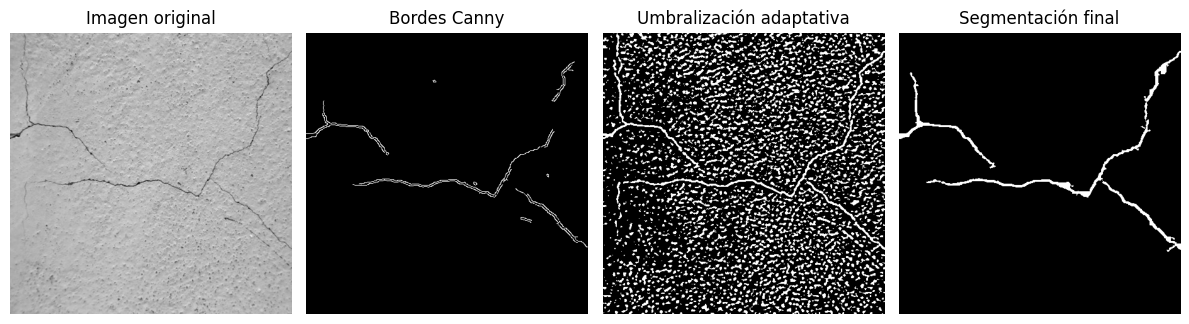

Inference time for segment_cracks: 1.6924 seconds


In [ ]:
# Choose an image path from our small test set
image_path = test_paths[100]

# Measure inference time with visualization
start_time = time.time()
result, mask = better_segmentation(image_path, params = best_params_iou, vis=True)
end_time = time.time()

inference_time = end_time - start_time

print(f"Inference time for segment_cracks: {inference_time:.4f} seconds")

In [ ]:
accs = []
ious = []
for pdx, path in enumerate(tqdm.tqdm(test_paths)):
  result, mask = better_segmentation(path, params = best_params_iou)
  acc = accuracy_score(mask, result)
  iou = intersection_over_union(mask, result)
  accs.append(acc)
  ious.append(iou)

100%|██████████| 169/169 [00:06<00:00, 27.35it/s]


In [ ]:
# print mean accuracy and mean iou in %
print(f"Mean accuracy: {np.mean(accs) * 100:.2f}%")
print(f"Mean IoU: {np.mean(ious) * 100:.2f}%")

Mean accuracy: 63.81%
Mean IoU: 11.59%


### Maximización `Accuracy`

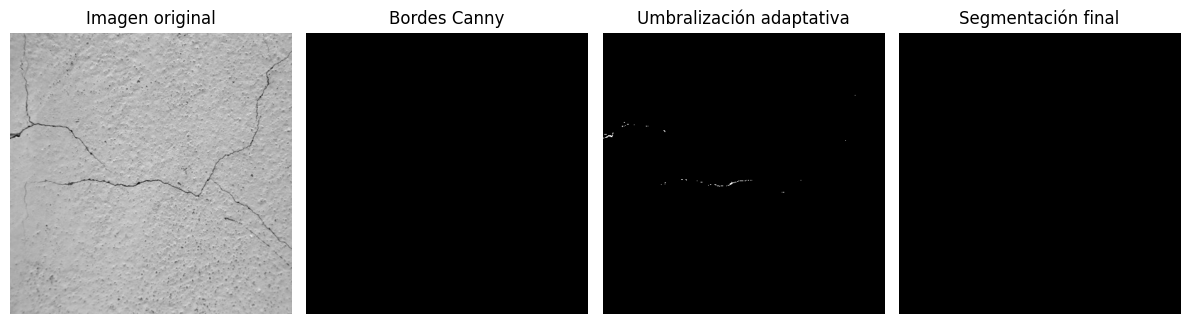

Inference time for segment_cracks: 0.8915 seconds


In [ ]:
# Choose an image path from our small test set
image_path = test_paths[100]

# Measure inference time with visualization
start_time = time.time()
result, mask = better_segmentation(image_path, params = best_params_acc, vis=True)
end_time = time.time()

inference_time = end_time - start_time

print(f"Inference time for segment_cracks: {inference_time:.4f} seconds")

In [ ]:
accs = []
ious = []
for pdx, path in enumerate(tqdm.tqdm(test_paths)):
  result, mask = better_segmentation(path, params = best_params_acc)
  acc = accuracy_score(mask, result)
  iou = intersection_over_union(mask, result)
  accs.append(acc)
  ious.append(iou)

100%|██████████| 169/169 [00:13<00:00, 12.47it/s]


In [ ]:
# print mean accuracy and mean iou in %
print(f"Mean accuracy: {np.mean(accs) * 100:.2f}%")
print(f"Mean IoU: {np.mean(ious) * 100:.2f}%")

Mean accuracy: 90.04%
Mean IoU: 2.51%


### Maximización `IoU + Accuracy`

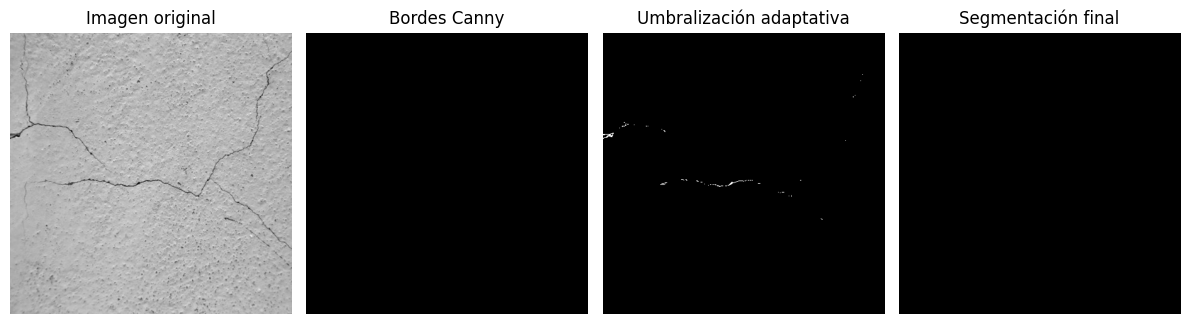

Inference time for segment_cracks: 0.9067 seconds


In [ ]:
# Choose an image path from our small test set
image_path = test_paths[100]

# Measure inference time with visualization
start_time = time.time()
result, mask = better_segmentation(image_path, params = best_params_comb, vis=True)
end_time = time.time()

inference_time = end_time - start_time

print(f"Inference time for segment_cracks: {inference_time:.4f} seconds")

In [ ]:
accs = []
ious = []
for pdx, path in enumerate(tqdm.tqdm(test_paths)):
  result, mask = better_segmentation(path, params = best_params_comb)
  acc = accuracy_score(mask, result)
  iou = intersection_over_union(mask, result)
  accs.append(acc)
  ious.append(iou)

100%|██████████| 169/169 [00:13<00:00, 12.51it/s]


In [ ]:
# print mean accuracy and mean iou in %
print(f"Mean accuracy: {np.mean(accs) * 100:.2f}%")
print(f"Mean IoU: {np.mean(ious) * 100:.2f}%")

Mean accuracy: 89.58%
Mean IoU: 3.47%


# La idea es maximizar el mean accuracy y el mean IoU, pero este es un problema complejo, no se asuste si no logra resultados "decentes"

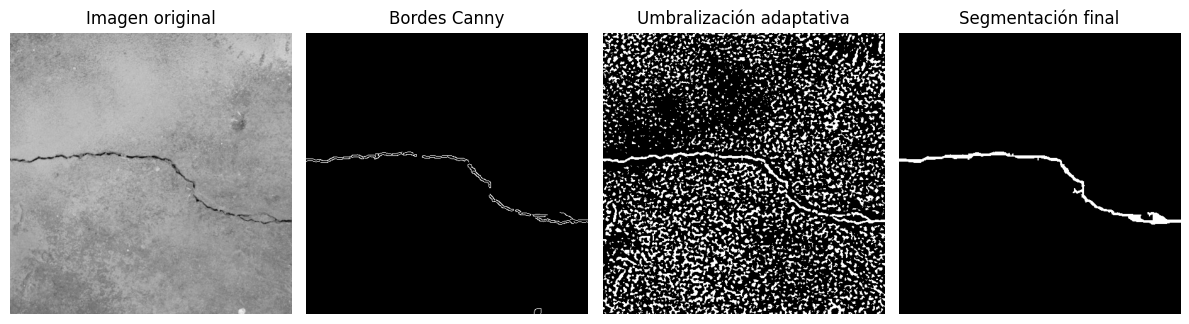

Inference time for segment_cracks: 1.9902 seconds


In [64]:
# Choose an image path from our small test set
image_path = '/content/drive/MyDrive/crack_segmentation_dataset/test/images/Volker_DSC01664_168_876_1650_1486.jpg'

# Measure inference time with visualization
start_time = time.time()
result, mask = better_segmentation(image_path, params = best_params_iou, vis=True)
end_time = time.time()

inference_time = end_time - start_time

print(f"Inference time for segment_cracks: {inference_time:.4f} seconds")

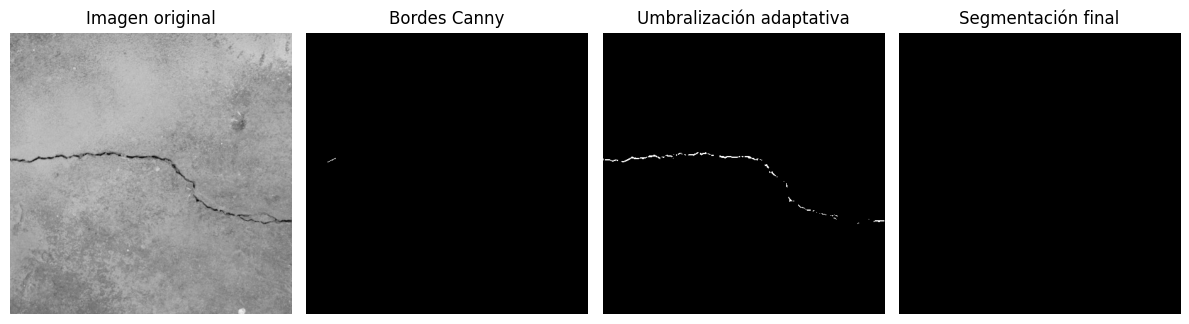

Inference time for segment_cracks: 2.0400 seconds


In [65]:
# Choose an image path from our small test set
image_path = '/content/drive/MyDrive/crack_segmentation_dataset/test/images/Volker_DSC01664_168_876_1650_1486.jpg'

# Measure inference time with visualization
start_time = time.time()
result, mask = better_segmentation(image_path, params = best_params_acc, vis=True)
end_time = time.time()

inference_time = end_time - start_time

print(f"Inference time for segment_cracks: {inference_time:.4f} seconds")

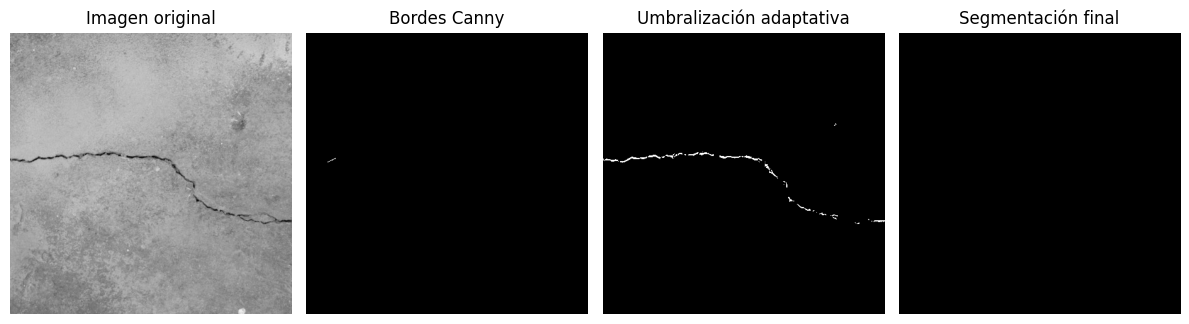

Inference time for segment_cracks: 0.5902 seconds


In [66]:
# Choose an image path from our small test set
image_path = '/content/drive/MyDrive/crack_segmentation_dataset/test/images/Volker_DSC01664_168_876_1650_1486.jpg'

# Measure inference time with visualization
start_time = time.time()
result, mask = better_segmentation(image_path, params = best_params_comb, vis=True)
end_time = time.time()

inference_time = end_time - start_time

print(f"Inference time for segment_cracks: {inference_time:.4f} seconds")